In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Markdown as md, Latex, Math

import statsmodels.api as sm
from patsy import dmatrices
import yfinance as yf
from datetime import datetime

# import wrds
# connection = wrds.Connection()

from tqdm.notebook import tqdm
tqdm.pandas()

%matplotlib inline
plt.style.use("bmh")

# Helper Functions

In [80]:
def convert_to_date(date):
    return pd.to_datetime(date[:4]+"/"+date[4:6]+"/"+date[6:]).date()

# convert_to_date("19721231")

def get_rnd(xrd_list: pd.Series)->pd.Series:
    '''Function to calculate R&D investment over the last 5 years'''
    return xrd_list.rolling(window=5).apply(lambda x: (np.array([0.2, 0.4, 0.6, 0.8, 0.1]) @ np.array(x)))
# get_rnd(yearly_xrd.iloc[-1]).tail(10)

def assign_quantile(rcd_list: pd.Series)->pd.Series:
    '''Function to assign each LPERMNO to a quantile depending on its R&D Investment'''
    arr = pd.qcut(rcd_list[rcd_list != 0.0], q = 5, labels= ["Low","q2","q3","q4","High"], duplicates= "drop")
    arr = arr.cat.add_categories('N/A R&D')

    for idx in rcd_list[rcd_list == 0].index:
        arr[idx] = "N/A R&D"
    return arr

# Read CCM Fundamentals Annual

In [93]:
ccm_fundamentals_annual = pd.read_csv("df_fa.csv")

ccm_fundamentals_annual["fyear"] = ccm_fundamentals_annual["datadate"].progress_apply(lambda x: convert_to_date(str(x)).year)
ccm_fundamentals_annual["year"] = ccm_fundamentals_annual["fyear"]+1
ccm_fundamentals_annual["me"] = ccm_fundamentals_annual[["csho", "prcc_c"]].apply(lambda r: (r["csho"]*r["prcc_c"]), axis = 1)

# USD Only
ccm_fundamentals_annual = ccm_fundamentals_annual[ccm_fundamentals_annual["curcd"] == "USD"]

# Positive ME only:
ccm_fundamentals_annual = ccm_fundamentals_annual[ccm_fundamentals_annual["me"] > 0]

# SIC Codes
ccm_fundamentals_annual["sic"] = ccm_fundamentals_annual[["sic","sich"]].apply(lambda row: (row["sich"] if np.isnan(row["sic"]) else row["sic"]), axis =1)
ccm_fundamentals_annual = ccm_fundamentals_annual.drop("sich", axis = 1)

ccm_fundamentals_annual

  0%|          | 0/276007 [00:00<?, ?it/s]

,GVKEY,LPERMNO,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,cusip,curcd,csho,xrd,exchg,costat,prcc_c,prcc_f,sic,year,me
0,1000,25881,19761231,1976,INDL,C,D,STD,AE.2,000032102,USD,2.207,NaN,12,I,5.7500,5.7500,3089.0,1977,12.690250
1,1000,25881,19771231,1977,INDL,C,D,STD,AE.2,000032102,USD,2.226,NaN,12,I,9.2500,9.2500,3089.0,1978,20.590500
2,1001,10015,19831231,1983,INDL,C,D,STD,AMFD.,000165100,USD,3.568,0.000,14,I,7.2500,7.2500,5812.0,1984,25.868000
3,1001,10015,19841231,1984,INDL,C,D,STD,AMFD.,000165100,USD,3.568,NaN,14,I,3.7500,3.7500,5812.0,1985,13.380000
4,1001,10015,19851231,1985,INDL,C,D,STD,AMFD.,000165100,USD,3.988,0.000,14,I,10.1250,10.1250,5812.0,1986,40.378500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276002,332115,80577,20201231,2020,INDL,C,D,STD,ARMP,04216R102,USD,18.688,14.444,12,A,2.9849,2.9849,2836.0,2021,55.781811
276003,335466,14756,20191231,2019,INDL,C,D,STD,HOFSQ,G4511M108,USD,25.662,NaN,19,A,1.0173,1.0173,4400.0,2020,26.105953
276004,339965,19654,20210131,2021,INDL,C,D,STD,SNOW,833445109,USD,287.918,237.946,11,A,281.4000,272.4500,7370.0,2022,81020.125200
276005,345920,20194,20201231,2020,INDL,C,D,STD,HYFM,44888K209,USD,33.500,NaN,14,A,52.5800,52.5800,3524.0,2021,1761.430000


In [94]:
yearly_xrd = ccm_fundamentals_annual.groupby(["LPERMNO","year"])["xrd","me"].mean().unstack()
yearly_xrd

/var/folders/y3/v6fyb_rs72bcn7ftc3lvwvmw0000gn/T/ipykernel_70174/2921738248.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  yearly_xrd = ccm_fundamentals_annual.groupby(["LPERMNO","year"])["xrd","me"].mean().unstack()


xrd                                               ...          me  \
year    1977 1978 1979 1980 1981 1982 1983 1984 1985 1986  ...        2013   
LPERMNO                                                    ...               
10000    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
10001    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...    78.09210   
10002    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
10003    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
10005    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...         ...   
93432    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
93433    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...    19.16053   
93434    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...    53.05956   
93435    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...         NaN   
93436    NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  3868.42818   

                                                                           \
year             2014         2015         2016         2017         2018   
LPERMNO                                                                     
10000             NaN          NaN          NaN          NaN          NaN   
10001       83.929560    115.57776     78.26225    132.02600          NaN   
10002             NaN          NaN          NaN          NaN          NaN   
10003             NaN          NaN          NaN          NaN          NaN   
10005             NaN          NaN          NaN          NaN          NaN   
...               ...          ...          ...          ...          ...   
93432             NaN          NaN          NaN          NaN          NaN   
93433       16.114140      3.14358     44.97500     20.05885      8.18545   
93434       80.508800     46.56000     56.77588     78.48060     70.12200   
93435             NaN          NaN          NaN          NaN          NaN   
93436    18516.456039  27954.26808  31543.31425  34523.97009  52554.94595   

                                                      
year             2019        2020          2021 2022  
LPERMNO                                               
10000             NaN         NaN           NaN  NaN  
10001             NaN         NaN           NaN  NaN  
10002             NaN         NaN           NaN  NaN  
10003             NaN         NaN           NaN  NaN  
10005             NaN         NaN           NaN  NaN  
...               ...         ...           ...  ...  
93432             NaN         NaN           NaN  NaN  
93433        4.961642         NaN           NaN  NaN  
93434       44.060830     69.8838      97.95869  NaN  
93435             NaN         NaN           NaN  NaN  
93436    57442.278400  75717.7300  677443.20000  NaN  

[25331 rows x 92 columns]

Calculate $ RCD_t = f(XRD_t, XRD_{t-1}, XRD_{t-2}, XRD_{t-3}, XRD_{t-4}, XRD_{t-5}) / ME_t $

In [95]:
yearly_rcd = yearly_xrd["xrd"].apply(lambda row: (get_rnd(row)), axis = 1)
yearly_rcd = (yearly_rcd/yearly_xrd["me"]).T
yearly_rcd = yearly_rcd.stack()
# yearly_rcd = yearly_rcd.dropna(how="all")
yearly_rcd

year  LPERMNO
1981  10006      0.023672
      10057      0.049609
      10145      0.073265
      10153      0.259662
      10161      0.015693
                   ...   
2022  92471      0.000000
      93096      0.000000
      93123      0.011472
      93347      0.000000
      93373      0.000000
Length: 75528, dtype: float64

In [97]:
yearly_rcd_class = yearly_rcd.groupby(level=0).progress_apply(lambda x: assign_quantile(x))
yearly_rcd_class.to_csv("bins.csv")
yearly_rcd_class = pd.read_csv("bins.csv").rename({"0":"bin"}, axis = 1).astype("int", errors= "ignore")
yearly_rcd_class["bin"] = yearly_rcd_class["bin"].astype("category")
yearly_rcd_class.head() # keeping nan's so that they can be dropped and we'll get the required values

  0%|          | 0/42 [00:00<?, ?it/s]

,year,year.1,LPERMNO,bin
0,1981,1981,10006,q2
1,1981,1981,10057,q3
2,1981,1981,10145,q3
3,1981,1981,10153,High
4,1981,1981,10161,Low


# Read CRSP Monthly Stock data

In [98]:
crsp_monthly_data = pd.read_csv("df_ms.csv", low_memory= False)
print("Parsing Dates")
crsp_monthly_data["date"] = crsp_monthly_data["date"].astype("str").progress_apply(lambda x: convert_to_date(x))

print("Add Year")
crsp_monthly_data["year"] = crsp_monthly_data["date"].progress_apply(lambda x: x.year)

print("Add Month")
crsp_monthly_data["month"] = crsp_monthly_data["date"].progress_apply(lambda x: x.month)

print("Add MarketCap")
crsp_monthly_data["mrktcap"] = abs(crsp_monthly_data['PRC'])*crsp_monthly_data['SHROUT']

crsp_monthly_data.drop_duplicates(["PERMNO", "date"], inplace= True)

crsp_monthly_data.set_index("PERMNO", inplace= True)
crsp_monthly_data

Parsing Dates


  0%|          | 0/3823198 [00:00<?, ?it/s]

Add Year


  0%|          | 0/3823198 [00:00<?, ?it/s]

Add Month


  0%|          | 0/3823198 [00:00<?, ?it/s]

Add MarketCap


,date,SHRCD,SICCD,TICKER,SHRCLS,PRC,RET,SHROUT,CFACPR,CFACSHR,year,month,mrktcap
PERMNO,,,,,,,,,,,,,
10000,1985-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1985,12,NaN
10000,1986-01-31,10.0,3990,OMFGA,A,-4.37500,C,3680.0,1.0,1.0,1986,1,1.610000e+04
10000,1986-02-28,10.0,3990,OMFGA,A,-3.25000,-0.257143,3680.0,1.0,1.0,1986,2,1.196000e+04
10000,1986-03-31,10.0,3990,OMFGA,A,-4.43750,0.365385,3680.0,1.0,1.0,1986,3,1.633000e+04
10000,1986-04-30,10.0,3990,OMFGA,A,-4.00000,-0.098592,3793.0,1.0,1.0,1986,4,1.517200e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93436,2020-08-31,11.0,9999,TSLA,NaN,498.32001,0.741452,931809.0,1.0,1.0,2020,8,4.643391e+08
93436,2020-09-30,11.0,9999,TSLA,NaN,429.01001,-0.139087,948000.0,1.0,1.0,2020,9,4.067015e+08
93436,2020-10-30,11.0,9999,TSLA,NaN,388.04001,-0.095499,947901.0,1.0,1.0,2020,10,3.678235e+08


In [99]:
# Filter for Share class = A or missing
crsp_monthly_data = crsp_monthly_data[(crsp_monthly_data["SHRCLS"] == "A")|(crsp_monthly_data["SHRCLS"].isna())]

# Filter for Share Code = 10 or 11
crsp_monthly_data = crsp_monthly_data[(crsp_monthly_data["SHRCD"] == 10)|(crsp_monthly_data["SHRCD"] == 11)]

# Remove Financial Companies
crsp_monthly_data = crsp_monthly_data[pd.to_numeric(crsp_monthly_data["SICCD"], errors= "coerce").notnull()]
crsp_monthly_data["SICCD"] = crsp_monthly_data["SICCD"].astype("int")
crsp_monthly_data = crsp_monthly_data[(crsp_monthly_data["SICCD"] < 6000)|(crsp_monthly_data["SICCD"] > 6999)]

# B in RET occours when none of the PERMNO entries have any price. Thus no return can exist. Thus, dropping
crsp_monthly_data = crsp_monthly_data.drop(crsp_monthly_data[crsp_monthly_data["RET"] == "B"].index).dropna(subset=["RET"])#.reset_index(drop = True)

# C in RET occours when the previous price does not exist. thus returns can not be calculated.
crsp_monthly_data["RET"] = crsp_monthly_data["RET"].replace("C",0.0).astype("float")

crsp_monthly_data

,date,SHRCD,SICCD,TICKER,SHRCLS,PRC,RET,SHROUT,CFACPR,CFACSHR,year,month,mrktcap
PERMNO,,,,,,,,,,,,,
10000,1986-01-31,10.0,3990,OMFGA,A,-4.37500,0.000000,3680.0,1.0,1.0,1986,1,1.610000e+04
10000,1986-02-28,10.0,3990,OMFGA,A,-3.25000,-0.257143,3680.0,1.0,1.0,1986,2,1.196000e+04
10000,1986-03-31,10.0,3990,OMFGA,A,-4.43750,0.365385,3680.0,1.0,1.0,1986,3,1.633000e+04
10000,1986-04-30,10.0,3990,OMFGA,A,-4.00000,-0.098592,3793.0,1.0,1.0,1986,4,1.517200e+04
10000,1986-05-30,10.0,3990,OMFGA,A,-3.10938,-0.222656,3793.0,1.0,1.0,1986,5,1.179388e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93436,2020-08-31,11.0,9999,TSLA,NaN,498.32001,0.741452,931809.0,1.0,1.0,2020,8,4.643391e+08
93436,2020-09-30,11.0,9999,TSLA,NaN,429.01001,-0.139087,948000.0,1.0,1.0,2020,9,4.067015e+08
93436,2020-10-30,11.0,9999,TSLA,NaN,388.04001,-0.095499,947901.0,1.0,1.0,2020,10,3.678235e+08


**Assumption:**

Not discarding years with <12 month returns

In [102]:
crsp_monthly_avg_returns = crsp_monthly_data.reset_index()[["PERMNO", "year", "month", "RET"]].fillna(0).groupby(["year", "month", "PERMNO"])["RET"].agg("mean")
crsp_monthly_avg_returns = crsp_monthly_avg_returns.reset_index().rename({"PERMNO":"LPERMNO"}, axis = 1)
crsp_monthly_avg_returns

,year,month,LPERMNO,RET
0,1976,1,10006,0.211039
1,1976,1,10014,0.400000
2,1976,1,10050,0.296296
3,1976,1,10057,0.174603
4,1976,1,10058,0.272727
...,...,...,...,...
2073750,2020,12,93422,0.484472
2073751,2020,12,93423,0.109665
2073752,2020,12,93426,0.076239
2073753,2020,12,93434,0.122605


# Merge Datasets

In [103]:
df_merged = pd.merge(yearly_rcd_class, crsp_monthly_avg_returns, how = 'inner', on = ['LPERMNO','year'], validate='1:m')
df_merged

,year,year.1,LPERMNO,bin,month,RET
0,1981,1981,10006,q2,1,0.108696
1,1981,1981,10006,q2,2,-0.022059
2,1981,1981,10006,q2,3,-0.005013
3,1981,1981,10006,q2,4,-0.066327
4,1981,1981,10006,q2,5,0.066995
...,...,...,...,...,...,...
650968,2020,2020,93423,N/A R&D,8,0.249569
650969,2020,2020,93423,N/A R&D,9,-0.065808
650970,2020,2020,93423,N/A R&D,10,0.065025
650971,2020,2020,93423,N/A R&D,11,0.421369


bin             High       Low   N/A R&D        q2        q3        q4
year month                                                            
1981 1      0.017218 -0.039854  0.022571 -0.011324 -0.005216  0.014579
     2      0.003161  0.011430  0.024847  0.009206  0.021814  0.009266
     3      0.102942  0.074171  0.098354  0.092792  0.082641  0.083322
     4      0.034347  0.014034  0.036958  0.031257  0.034135  0.046676
     5      0.041007  0.032037  0.042356  0.040749  0.028610  0.031915

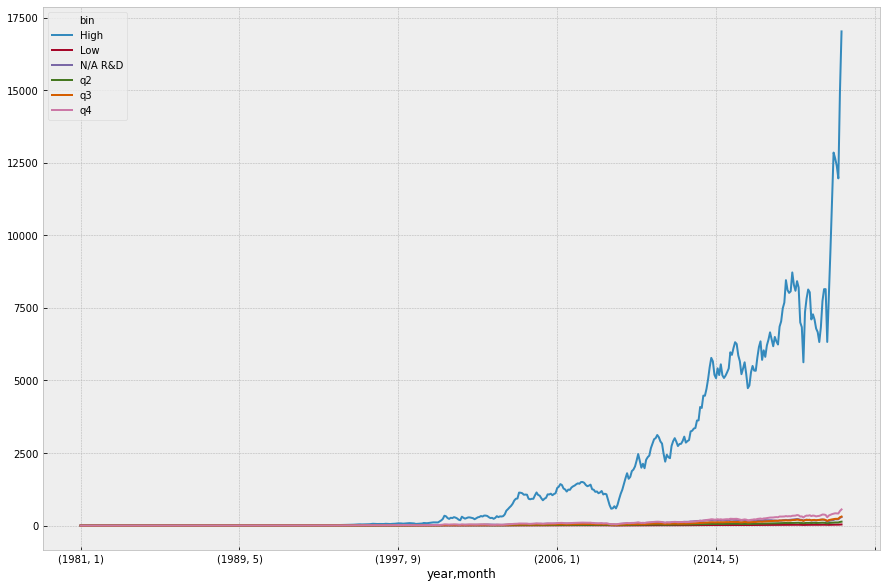

In [105]:
monthly_rets_by_quantile = df_merged.groupby(["year","month","bin"])["RET"].mean().unstack()
((monthly_rets_by_quantile + 1).cumprod() - 1).plot(figsize = (15,10))
monthly_rets_by_quantile.head()

bin,High,Low,N/A R&D,q2,q3,q4
year,,,,,,
1981,0.006504,0.000409,0.013432,0.003536,0.002735,0.006718
1982,0.036402,0.012895,0.032970,0.018333,0.020375,0.025392
1983,0.038944,0.021494,0.045392,0.026817,0.025919,0.032565
1984,-0.005360,-0.005357,0.002419,-0.003475,-0.006187,-0.004796
1985,0.019774,0.021600,0.020813,0.022893,0.021040,0.015204


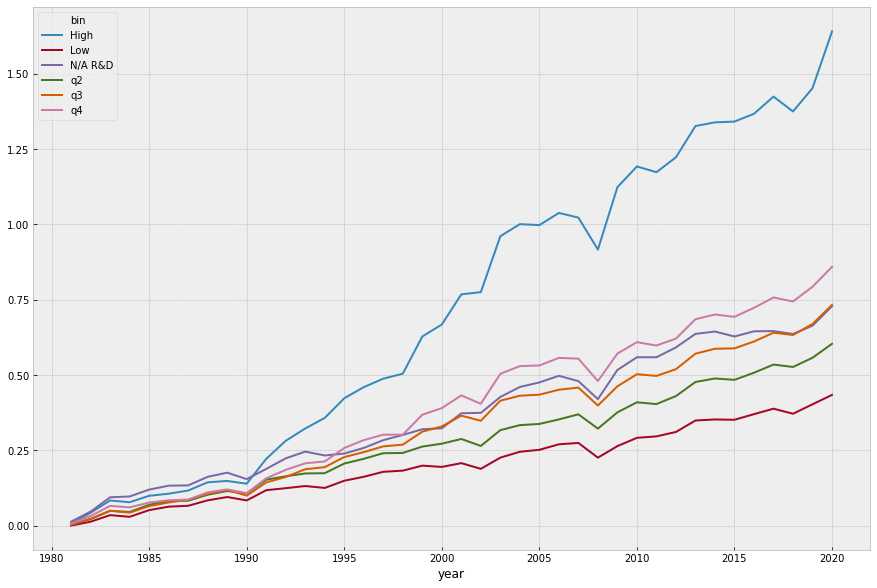

In [107]:
annual_rets_by_quantile = df_merged.groupby(["year","bin"])["RET"].mean().unstack()
((annual_rets_by_quantile + 1).cumprod() - 1).plot(figsize = (15,10))
annual_rets_by_quantile.head()

# (Equally weighted) All time